### Project Setup

In [2]:
# Needed for importing target encoder, restart after running
!pip install --upgrade scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 36.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [3]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.7 MB/s eta 0:00:00


In [1]:
!pip install transformers

In [175]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import re
from datetime import datetime
from google.colab import userdata
import os
import google_auth_oauthlib.flow
import googleapiclient.discovery
import googleapiclient.errors
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import BertTokenizer, TFBertModel
from sklearn.dummy import DummyRegressor

pd.set_option("display.max_colwidth", None)

In [2]:
# Load data from github
!wget https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/US_category_id.json
!wget https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/USvideos.csv

--2024-06-12 17:08:18--  https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/US_category_id.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8496 (8.3K) [text/plain]
Saving to: ‘US_category_id.json’

US_category_id.json 100%[===================>]   8.30K  --.-KB/s    in 0s      

2024-06-12 17:08:18 (49.1 MB/s) - ‘US_category_id.json’ saved [8496/8496]

--2024-06-12 17:08:18--  https://raw.githubusercontent.com/julietlawton/youtube-views-prediction/main/youtube-dataset/USvideos.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP reques

In [44]:
# Read data into dataframe
youtube_df = pd.read_csv('USvideos.csv')

In [45]:
# Extract video category labels and ids from auxillary JSON file
with open("US_category_id.json", "r") as f:
    data = json.load(f)

# Create a dictionary mapping ids to lablels
categories = {}
for item in data['items']:
    id = int(item['id'])
    category = item['snippet']['title']
    categories[id] = category

print(categories)

{1: 'Film & Animation', 2: 'Autos & Vehicles', 10: 'Music', 15: 'Pets & Animals', 17: 'Sports', 18: 'Short Movies', 19: 'Travel & Events', 20: 'Gaming', 21: 'Videoblogging', 22: 'People & Blogs', 23: 'Comedy', 24: 'Entertainment', 25: 'News & Politics', 26: 'Howto & Style', 27: 'Education', 28: 'Science & Technology', 29: 'Nonprofits & Activism', 30: 'Movies', 31: 'Anime/Animation', 32: 'Action/Adventure', 33: 'Classics', 34: 'Comedy', 35: 'Documentary', 36: 'Drama', 37: 'Family', 38: 'Foreign', 39: 'Horror', 40: 'Sci-Fi/Fantasy', 41: 'Thriller', 42: 'Shorts', 43: 'Shows', 44: 'Trailers'}


### Preprocessing

In [46]:
# Add category labels for each video
youtube_df['category_label'] = youtube_df['category_id'].apply(lambda x: categories[x])

In [47]:
display(youtube_df.info(verbose=True, show_counts=True))
youtube_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

None

video_id trending_date  \
0  2kyS6SvSYSE      17.14.11   
1  1ZAPwfrtAFY      17.14.11   
2  5qpjK5DgCt4      17.14.11   
3  puqaWrEC7tY      17.14.11   
4  d380meD0W0M      17.14.11   

                                                            title  \
0                              WE WANT TO TALK ABOUT OUR MARRIAGE   
1  The Trump Presidency: Last Week Tonight with John Oliver (HBO)   
2           Racist Superman | Rudy Mancuso, King Bach & Lele Pons   
3                                Nickelback Lyrics: Real or Fake?   
4                                        I Dare You: GOING BALD!?   

           channel_title  category_id              publish_time  \
0           CaseyNeistat           22  2017-11-13T17:13:01.000Z   
1        LastWeekTonight           24  2017-11-13T07:30:00.000Z   
2           Rudy Mancuso           23  2017-11-12T19:05:24.000Z   
3  Good Mythical Morning           24  2017-11-13T11:00:04.000Z   
4               nigahiga           24  2017-11-12T18:01:41.000Z   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            tags  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                SHANtell martin   
1                                                                                                                                                                                                                                                                                                                                                                                         last week tonight trump presidency|"last week tonight donald trump"|"john oliver trump"|"donald trump"   
2                                                                                                                                                                     racist superman|"rudy"|"mancuso"|"king"|"bach"|"racist"|"superman"|"love"|"rudy mancuso poo bear black white official music video"|"iphone x by pineapple"|"lelepons"|"hannahstocking"|"rudymancuso"|"inanna"|"anwar"|"sarkis"|"shots"|"shotsstudios"|"alesso"|"anitta"|"brazil"|"Getting My Driver's License | Lele Pons"   
3  rhett and link|"gmm"|"good mythical morning"|"rhett and link good mythical morning"|"good mythical morning rhett and link"|"mythical morning"|"Season 12"|"nickelback lyrics"|"nickelback lyrics real or fake"|"nickelback"|"nickelback songs"|"nickelback song"|"rhett link nickelback"|"gmm nickelback"|"lyrics (website category)"|"nickelback (musical group)"|"rock"|"music"|"lyrics"|"chad kroeger"|"canada"|"music (industry)"|"mythical"|"gmm challenge"|"comedy"|"funny"|"challenge"   
4                                                                                                                                                                                                                                                                                                                                                                       ryan|"higa"|"higatv"|"nigahiga"|"i dare you"|"idy"|"rhpc"|"dares"|"no truth"|"comments"|"comedy"|"funny"|"stupid"|"fail"   

     views   likes  dislikes  comment_count  \
0   748374   57527      2966          15954

In [48]:
# Reorder the data so that all the duplicate videos appear together, ordered by views
youtube_df.sort_values(['views', 'video_id'], inplace=True)

# Remove all duplicate videos, keeping the last instance of each
youtube_df.drop_duplicates(subset=['video_id'], keep='last', inplace=True)
youtube_df.reset_index(drop=True, inplace=True)
youtube_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6351 entries, 0 to 6350
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                6351 non-null   object
 1   trending_date           6351 non-null   object
 2   title                   6351 non-null   object
 3   channel_title           6351 non-null   object
 4   category_id             6351 non-null   int64 
 5   publish_time            6351 non-null   object
 6   tags                    6351 non-null   object
 7   views                   6351 non-null   int64 
 8   likes                   6351 non-null   int64 
 9   dislikes                6351 non-null   int64 
 10  comment_count           6351 non-null   int64 
 11  thumbnail_link          6351 non-null   object
 12  comments_disabled       6351 non-null   bool  
 13  ratings_disabled        6351 non-null   bool  
 14  video_error_or_removed  6351 non-null   bool  
 15  desc

In [49]:
# View how many videos are in each category
youtube_df['category_label'].value_counts()

category_label
Entertainment            1621
Music                     801
Howto & Style             594
Comedy                    544
News & Politics           504
People & Blogs            495
Sports                    449
Science & Technology      381
Film & Animation          320
Education                 251
Pets & Animals            140
Gaming                    103
Autos & Vehicles           71
Travel & Events            59
Nonprofits & Activism      14
Shows                       4
Name: count, dtype: int64

In [50]:
# View trending date range
print(f"{youtube_df['trending_date'].min()} - {youtube_df['trending_date'].max()}")

17.01.12 - 18.31.05


In [51]:
# Convert timestamps to UTC
youtube_df['publish_time'] = youtube_df['publish_time'].apply(lambda row: datetime.fromisoformat(row.replace("Z", "+00:00")))

In [52]:
# Extract hour, time of day, and day of week
# Morning 5 am to 12 pm (noon)
# Afternoon 12 pm to 5 pm
# Evening 5 pm to 9 pm
# Night 9 pm to 4 am
def get_time_day(row):
  day = row.weekday()
  hour = row.hour
  period = 0 if hour >= 5 and hour < 12 else \
   (1 if hour >= 12 and hour < 17 else (2 if hour >= 17 and hour < 21 else 3))
  return pd.Series([hour, period, day], index=['hour', 'time_of_day', 'day_of_week'])

youtube_df[['hour', 'time_of_day', 'day_of_week']] = youtube_df['publish_time'].apply(get_time_day)
youtube_df.head()

video_id trending_date  \
0  y6KYFcta4SE      18.28.01   
1  -JVITToppE0      17.17.11   
2  dQMZLXaa1L8      18.29.01   
3  zeQaJGkFyqQ      18.18.01   
4  qg0GdM60syI      17.14.11   

                                              title     channel_title  \
0  1 dead, others injured after Ky. school shooting             Newsy   
1     Coach Taggart Monday Presser Ahead of Arizona     GoDucksdotcom   
2                                     Artwork Forge  Palo Alto Online   
3    Raw: 3 South Carolina Deputies, 1 Officer Shot  Associated Press   
4            Huffy Metaloid Bicycle Commercial 1997   90s Commercials   

   category_id              publish_time  \
0           25 2018-01-23 15:30:01+00:00   
1           17 2017-11-13 20:41:45+00:00   
2           17 2018-01-10 23:53:56+00:00   
3           25 2018-01-16 12:16:44+00:00   
4           27 2017-03-31 21:46:53+00:00   

                                                                                                                                                                                                                                                                                                                                                                                                                               tags  \
0                                                                                                                                                                                                                                                                               shooting|"kentucky"|"breaking news"|"u.s. news"|"marshall county high school"|"dead"|"fatality"|"injured"|"students"|"school"|"governor matt bevin"   
1                                                                                                                                                                                                                                                                                Oregon|"Ducks"|"college athletics"|"college football"|"college basketball"|"Tracktown USA"|"Track & Field"|"Hayward Field"|"Autzen Stadium"|"NIKE"   
2                                                                                                                                                                                                                                                                                                                                                                                                                            [none]   
3  news|"associated press"|"ap"|"ap online"|"associated press style"|"breaking news"|"latest news"|"business"|"finance"|"politics"|"local news"|"commentary"|"reports"|"current affairs"|"top news"|"headlines"|"news today"|"charlotte"|"north carolina"|"united states"|"north america"|"south carolina"|"national"|"regional (ap video-us only"|"charlotte police shooting"|"raw"|"south"|"carolina"|"deputies"|"officer"|"shot"   
4                                                                                                                                                                                                                                                                                                                                                                                                           90s commercials|"Huffy"   

   views  likes  dislikes  comment_count  \
0    559      9         0              4   
1    704     10         2              5   
2    745      1         0              0   
3    748      9         0              0   
4    773      2         0              0   

                                   thumbnail_link  comments_disabled  \
0  https://i.ytimg.com/vi/y6KYFcta4SE/default.jpg              False   
1  https://i.ytimg.com/vi/-JVITToppE0/default.jpg              False   
2  https://i.ytimg.com/vi/dQMZLXaa1L8/default.jpg              False   
3  https://i.ytim

In [53]:
# Encode time variables using angular distance
# Each pair of features represent (x, y) coordinates and must be kept together
# cosine maps to x and sine maps to y
youtube_df['hour_x_coord'] = np.cos(youtube_df['hour'] * (2 * np.pi / 24))
youtube_df['hour_y_coord'] = np.sin(youtube_df['hour'] * (2 * np.pi / 24))

youtube_df['time_of_day_x_coord'] = np.cos(youtube_df['time_of_day'] * (2 * np.pi / 4))
youtube_df['time_of_day_y_coord'] = np.sin(youtube_df['time_of_day'] * (2 * np.pi / 4))

youtube_df['day_of_week_x_coord'] = np.cos(youtube_df['day_of_week'] * (2 * np.pi / 7))
youtube_df['day_of_week_y_coord'] = np.sin(youtube_df['day_of_week'] * (2 * np.pi / 7))

youtube_df.head()


video_id trending_date  \
0  y6KYFcta4SE      18.28.01   
1  -JVITToppE0      17.17.11   
2  dQMZLXaa1L8      18.29.01   
3  zeQaJGkFyqQ      18.18.01   
4  qg0GdM60syI      17.14.11   

                                              title     channel_title  \
0  1 dead, others injured after Ky. school shooting             Newsy   
1     Coach Taggart Monday Presser Ahead of Arizona     GoDucksdotcom   
2                                     Artwork Forge  Palo Alto Online   
3    Raw: 3 South Carolina Deputies, 1 Officer Shot  Associated Press   
4            Huffy Metaloid Bicycle Commercial 1997   90s Commercials   

   category_id              publish_time  \
0           25 2018-01-23 15:30:01+00:00   
1           17 2017-11-13 20:41:45+00:00   
2           17 2018-01-10 23:53:56+00:00   
3           25 2018-01-16 12:16:44+00:00   
4           27 2017-03-31 21:46:53+00:00   

                                                                                                                                                                                                                                                                                                                                                                                                                               tags  \
0                                                                                                                                                                                                                                                                               shooting|"kentucky"|"breaking news"|"u.s. news"|"marshall county high school"|"dead"|"fatality"|"injured"|"students"|"school"|"governor matt bevin"   
1                                                                                                                                                                                                                                                                                Oregon|"Ducks"|"college athletics"|"college football"|"college basketball"|"Tracktown USA"|"Track & Field"|"Hayward Field"|"Autzen Stadium"|"NIKE"   
2                                                                                                                                                                                                                                                                                                                                                                                                                            [none]   
3  news|"associated press"|"ap"|"ap online"|"associated press style"|"breaking news"|"latest news"|"business"|"finance"|"politics"|"local news"|"commentary"|"reports"|"current affairs"|"top news"|"headlines"|"news today"|"charlotte"|"north carolina"|"united states"|"north america"|"south carolina"|"national"|"regional (ap video-us only"|"charlotte police shooting"|"raw"|"south"|"carolina"|"deputies"|"officer"|"shot"   
4                                                                                                                                                                                                                                                                                                                                                                                                           90s commercials|"Huffy"   

   views  likes  dislikes  ...   category_label hour  time_of_day  \
0    559      9         0  ...  News & Politics   15            1   
1    704     10         2  ...           Sports   20            2   
2    745      1         0  ...           Sports   23            3   
3    748      9         0  ...  News & Politics   12            1   
4    773      2         0  ...        Education   21            3   

   day_of_week  hour_x_coord  hour_y_coord time_of_day_x_coord  \
0            1     -0.707107 -7.071068e-01        6.123234e-17   
1            0      0.5

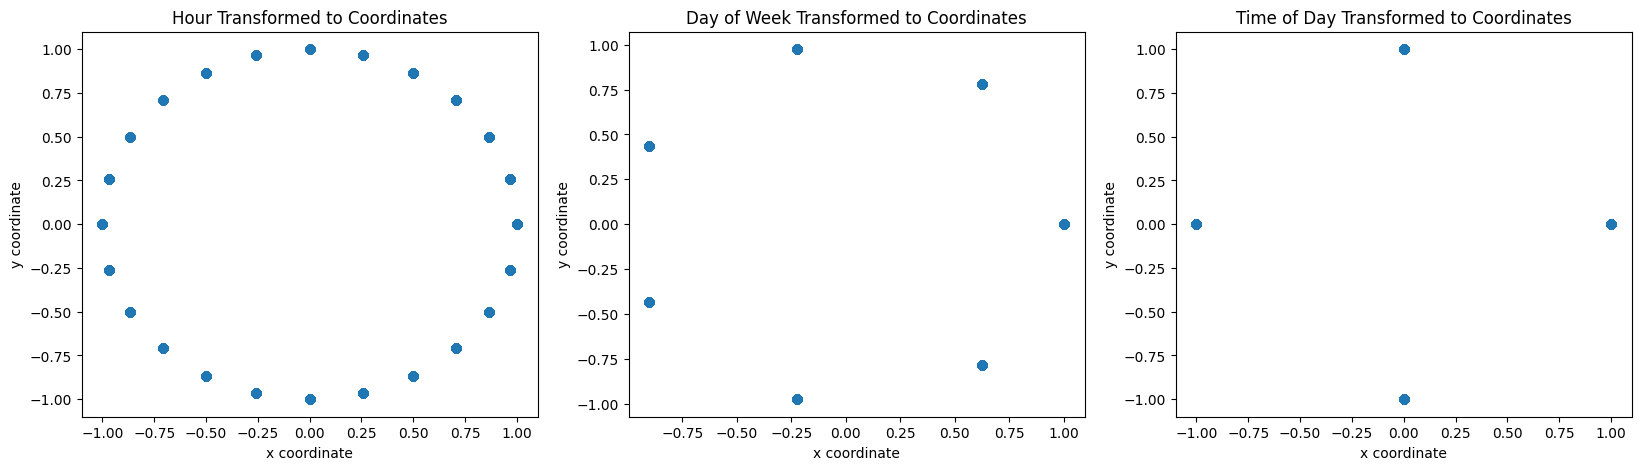

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0].scatter(youtube_df['hour_x_coord'], youtube_df['hour_y_coord'])
ax[0].set_title("Hour Transformed to Coordinates")
ax[0].set_xlabel("x coordinate")
ax[0].set_ylabel("y coordinate")

ax[1].scatter(youtube_df['day_of_week_x_coord'], youtube_df['day_of_week_y_coord'])
ax[1].set_title("Day of Week Transformed to Coordinates")
ax[1].set_xlabel("x coordinate")
ax[1].set_ylabel("y coordinate")

ax[2].scatter(youtube_df['time_of_day_x_coord'], youtube_df['time_of_day_y_coord'])
ax[2].set_title("Time of Day Transformed to Coordinates")
ax[2].set_xlabel("x coordinate")
ax[2].set_ylabel("y coordinate")
plt.show()

In [67]:
# Check for missing text values
print(f"Missing video descriptions: {youtube_df['description'].isna().sum()}")
print(f"Missing video titles: {youtube_df['title'].isna().sum()}")

Missing video descriptions: 98
Missing video titles: 0


In [113]:
# Remove noise (urls, emails) from the descriptions
def remove_noise(text):
  text = text.strip()
  text = re.sub(r'https?://\S+|www\.\S+', '', text)
  text = re.sub(r'\r', '', text)
  text = re.sub(r'\\n', ' ', text)
  text = re.sub(r'\s{2}', ' ', text)
  return text

youtube_df['description'] = youtube_df['description'].astype(str)
youtube_df['description']= youtube_df['description'].apply(remove_noise)

In [116]:
pd.DataFrame(youtube_df['description']).head(10)

description
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Kentucky Gov. Matt Bevin confirmed there was a shooting at a high school in western Kentucky. Learn more about this story at more videos like this at Newsy on Facebook: Newsy on Twitter: 
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Coach Taggart addresses the media ahead of the Duck's match up this weekend against the Arizona Wildcats. #GoDucks #DoSomething
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               Artwork Forge II - an art installation created by artist Toby Atticus Fraley, is currently on display in front of Palo Alto City Hall through April 2018.  By inserting four quarters into the machine, anyone can receive a custom-made piece of artwork sourced from what is currently trending on social media in the local vicinity.  Take a peek into what this little art machine can do.
3                                                             Three deputies and one police officer were shot and wounded in northern South Carolina early Tuesday. State police say a suspect was also wounded. The wounded officers were taken to a hospital in Charlotte, North Carolina. (Jan. 1

In [117]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = TFBertModel.from_pretrained("bert-base-cased")
text = "Kentucky Gov. Matt Bevin confirmed there was a shooting at a high school in western Kentucky. Learn more about this story at more videos like this at Newsy on Facebook: Newsy on Twitter:"
encoded_input = tokenizer(text, return_tensors='tf')
output = model(encoded_input)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
sentiment_analyzer = SentimentIntensityAnalyzer()
def analyze_sentiment(text):
  sentiment = sentiment_analyzer.polarity_scores(text)
  neg_score = sentiment['neg']
  neu_score = sentiment['neu']
  pos_score = sentiment['pos']
  overall_score = sentiment['compound']
  return pd.Series([neg_score, neu_score, pos_score, overall_score])

youtube_df[['title_neg_sentiment', 'title_neu_sentiment', 'title_pos_sentiment', 'title_overall_sentiment']] = youtube_df['title'].apply(analyze_sentiment)
youtube_df[['description_neg_sentiment', 'description_neu_sentiment', 'description_pos_sentiment', 'description_overall_sentiment']] = youtube_df['description'].apply(analyze_sentiment)

In [126]:
youtube_df[['title', 'description', 'title_neg_sentiment', 'title_neu_sentiment', 'title_pos_sentiment', 'title_overall_sentiment', 'description_neg_sentiment', 'description_neu_sentiment', 'description_pos_sentiment', 'description_overall_sentiment']].head()


title  \
0  1 dead, others injured after Ky. school shooting   
1     Coach Taggart Monday Presser Ahead of Arizona   
2                                     Artwork Forge   
3    Raw: 3 South Carolina Deputies, 1 Officer Shot   
4            Huffy Metaloid Bicycle Commercial 1997   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         description  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        Kentucky Gov. Matt Bevin confirmed there was a shooting at a high school in western Kentucky. Learn more about this story at more videos like this at Newsy on Facebook: Newsy on Twitter:    
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Coach Taggart addresses the media ahead of the Duck's match up this weekend against the Arizona Wildcats. #GoDucks #DoSomething   
2                                                                                                                                                                                          

In [136]:
# Display most negative and most positive sentiment for title and description
print("Most negative title")
display(youtube_df[['title', 'title_overall_sentiment']][youtube_df['title_overall_sentiment'] == youtube_df['title_overall_sentiment'].min()])

print("\nMost negative description")
display(youtube_df[['description', 'description_overall_sentiment']][youtube_df['description_overall_sentiment'] == youtube_df['description_overall_sentiment'].min()])

print("Most positive title")
display(youtube_df[['title', 'title_overall_sentiment']][youtube_df['title_overall_sentiment'] == youtube_df['title_overall_sentiment'].max()])

print("\nMost positive description")
display(youtube_df[['description', 'description_overall_sentiment']][youtube_df['description_overall_sentiment'] == youtube_df['description_overall_sentiment'].max()])

Most negative title


title  \
4182  THIS HAS TO STOP! INSTAGRAM TRENDS I HATED IN 2017 AND NEED TO DIE   

      title_overall_sentiment  
4182                  -0.9299


Most negative description


description  \
5313  In this video, Keaton, crying in the passenger seat, describes having milk poured on him and ham put down his clothes.  The anti-bullying video of a Union County middle schooler went viral over the weekend, garnering the attention of the Tennessee Titans and the University of Tennessee Vols football teams.  Kimberly Jones posted the video of her son, Keaton, on her Facebook page Friday shortly after 12:30 p.m. She said she had just picked Keaton up from school because he was too afraid to go to lunch as a result of bullying. ________________________________________________________________ FACEBOOK VIDEO: the record, Keaton asked to do this AFTER he had he me pick him up AGAIN because he was afraid to go to lunch. My kids are by no stretch perfect, & at home, he's as all boy as they come, but by all accounts he's good at school. Talk to your kids. I've even had friends of mine tell me they're kids were only nice to him to get him to mess with people. We all know how it feels to want to belong, but only a select few know how it really feels not to belong anywhere. ________________________________________________________________  ignore tags  Crying East Tennessee boy's viral anti-bullying video attracts attention of Vols, Titans Knoxville News Sentinel Heartbreaking story from young boy bullied because of how he looks KUTV 2News WATCH: Delanie Walker brings awareness to school bullying 247Sports Bullying Will Not Stop Me ... Jahmir's Story | The Maury Show Universal Pictures Migos, Nicki Minaj, Cardi B - MotorSport MigosVEVO YouTube Rewind: The Shape of 2017 | #YouTubeRewind YouTube Spotlight PewDiePie 2017 YouTube Rewind Rant! (Diss Track?) RiceGum YOUTUBERS REACT TO YOUTUBE REWIND 2017 FBE Dude vs. Wild - Nevada Mountains nigahiga How small a hole can a mouse get through? Experiments. Matthias Wandel Alita: Battle Angel | Official Trailer [HD] | 20th Century FOX 20th Century Fox Logic Solves a Rubik's Cube While Eating Spicy Wings | Hot Ones First We Feast STRANGER THINGS: A Bad Lip Reading Bad Lip Reading THE HARDEST GAME EVER MADE.... (Getting Over It) DanTDM Eugene Drinks Every State's Most Iconic Alcohol • The Try Vlog BuzzFeedVideo 'The Wilderness' - Kellz & The Truth Experiment - Official Music Video LATX Serayah Cuts the Beat & Goes In On Nick Cannon | Wild 'N Out | #Wildstyle MTV Logan Paul Vlogs NORMAN - THE RACLETTE ! NORMAN FAIT DES VIDÉOS JURASSIC WORLD 2: Fallen Kingdom Trailer (Extended) 2018 FilmSelect Trailer Everything You May Have Missed in the Jurassic World: Fallen Kingdom Trailer IGN Jerusalem, God, And The United Shursh The Late Show with Stephen Colbert ‪#ThomasFire‬ ‪#CreekFire‬ ‪#RyeFire‬ ‪#LilacFire ‬ ‪#SkirballFire ‬ ‪#LibertyFire ‬ Unbelievable Footage of Wildfire Spreading Through California The Majority Report with Sam Seder  The wildfires continue to burn in southern California. Keaton Jones video Keaton Jones video mom mother is Keaton Jones racist viral bully RiceGum  Explosive wildfire barrels through Southern California Fox News WATCH LIVE: Fire continues to rage in Southern California. Now | Wednesday, 6 December 2017 LIVE 🔴 California WILDFIRES OUTSPREADING, MASSIVE Evacuation NOW. 12.6.17 Horse runs for its life in bid to escape California wildfire The Telegraph  Blue Cut Fire Scorches 5,500 Acres Near Cajon Pass MotorCop MotoVlog ~ Blue Cut Fire And Random Chit-Chat RAW: Fast-moving brush fire explodes in Ventura county (Air Coverage) Artnewsive A Wildfire In Southern California Has Forced Thousands To Evacuate: See The Latest Footage | TIME Wildfire raging near Getty Center in Los Angeles and moving toward UCLA. 12.6.17 Live: A new brush fire has broken out near the Getty Center in Brentwood. 6.12.17 Fast-moving Creek fire threatens homes in California (sylmar fire) Artnewsive Wildfire devastation in California spreads The National  Wildfires turn California freeway into wall of flames USA TODAY As drivers headed down the 405 freeway, they were met with giant flames 

Most positive title


title  \
4280  INDIAN STREET FOOD Tour DEEP in PUNJAB, INDIA | BEST STREET FOOD in INDIA and BEST CURRY HEAVEN!   

      title_overall_sentiment  
4280                    0.945


Most positive description


description  \
4280  AMAZING Indian Street Food TOUR in Punjab, India! It has some of the Best Street Food in INDIA, it's a TRUE curry HEAVEN! We travel in India for street food, and went on a DEEP Street Food TOUR in Amritsar PUNJAB, to try some of the most AMAZING street food around the world! The Food Ranger (Trevor James) is in India eating Street Food! This truly was an amazing STREET FOOD ADVENTURE in INDIA with AMAZING curry, breakfast, and delicious restaurants with UNIQUE Indian food recipes and Indian dinner! If you love eating street food around the world and street food in India, or even all over Asia, you will love the street food in Amritsar. You can find street food everywhere, where everyone seems to cook delicious Indian recipes for curry and SPICY dishes all over the street. In one day, we had 7 delicious street foods all made in the PUNJAB style. I didn’t realize until after we finished eating, but we didn’t eat any meat or chicken at all! It was true vegetarian HEAVEN! We started out the day with an AMAZING Indian breakfast in two different Indian street food restaurants. The first was the famous Amritsar Kulcha. I’m pretty sure you can get this dish in Delhi, but here in Amritsar is the origin of this stuffed baked bread from HEAVEN. It’s stuffed with a spiced potato mix and onions. It’s sprinkled with a masala spice and then put DEEP into the Tandoori oven and baked. It’s served to you on a plate with Chole chickpea curry and onion chutney. The next AMAZING Breakfast we had on our street food tour was the Poori and Chole with Potato sabzi. A little similar with the chole, but the potato sabzi was nice and sweet and tangy and very UNIQUE! Afterwards, we took our TUK TUK around town for some more amazing street foods. We enjoyed a street corner tofu curry served with a pancake and then we went to have a sweet and sour buttermilk lassi. After this, we went to the LEGENDARY Kesar De Dhaba all vegetarian curry restaurant that uses PURE desi ghee. It was extremely flavourful and just a little spicy. We ordered the VEG thali and it was incredible! The paratha bread was so fluffy and covered in pure desi ghee, absolute HEAVEN! We also ate some dessert, a fruit kulfi ice cream! After this we went for a couple more street foods in Amritsar. We were exploring the back lanes and found an amazing mango fruit stall! It was dried and covered in a slightly spicy and sour and tangy sauce. There were a lot of flavours in this Indian recipe. It was spicy, sour, tangy, sweet, peppery, acidic, pungent, and made your mouth pucker when you ate it! Very UNIQUE! After this, we went for our final street food, an ICONIC street food in India, the samosa. It was stuffed with potato, cumin seeds, and spices. The addresses for these street food restaurants in Amritsar, India, are listed below: 1) Breakfast Street Food Kulcha at Monu Kulcha Hut Gali No, 10, Loharka Road, Ranjit Vihar, N.R.I. Colony, NRI Colony, Gumtala, Amritsar, Punjab 143001, India 2) Amazing Poori and Chole and desserts at Kanha Sweets Shop 1, Opposite Bijli Pehalwan Mandir, Lawrence Road, White Avenue, Amritsar 3) Fairly OK veg curry DEEP in the back lanes of Amritsar (honestly can’t remember this address, go for the Kesar De Dhaba instead). 4) Delicious Street Lassi at Ahuja Lassi Near Hindu College, Amritsar, India 5) BEST Vegetarian Curry in the WORLD @ Kesar De Dhaba, Amritsar 6) Amazing Mango sour and spicy dessert at Aam Papad: Ram lubhaya and sons 7) Potato Samosa at Raam samosey wala ABOUT THE FOOD RANGER  My name is Trevor James and I'm a hungry traveler and Mandarin learner that's currently living in Chengdu, Szechuan, China, eating up as much delicious . I enjoy tasting and documenting as many dishes as I can and I'm going to make videos for YOU along the way! Over the next few years, I'm going to travel around the world and document as much food as I can for you! I love delicious food! This channel will show you real Chinese food and real local food, not

### Data understanding - EDA

In [174]:
youtube_df.describe(include='all')

video_id trending_date  \
count          6351          6351   
unique         6351           205   
top     y6KYFcta4SE      18.14.06   
freq              1           199   
mean            NaN           NaN   
min             NaN           NaN   
25%             NaN           NaN   
50%             NaN           NaN   
75%             NaN           NaN   
max             NaN           NaN   
std             NaN           NaN   

                                                                               title  \
count                                                                           6351   
unique                                                                          6343   
top     Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures   
freq                                                                               2   
mean                                                                             NaN   
min                                                                              NaN   
25%                                                                              NaN   
50%                                                                              NaN   
75%                                                                              NaN   
max                                                                              NaN   
std                                                                              NaN   

       channel_title  category_id                         publish_time  \
count           6351  6351.000000                                 6351   
unique          2199          NaN                                  NaN   
top             ESPN          NaN                                  NaN   
freq              84          NaN                                  NaN   
mean             NaN    20.431271  2018-01-12 09:34:30.700204800+00:00   
min              NaN     1.000000            2006-07-23 08:24:11+00:00   
25%              NaN    17.000000            2017-12-13 04:38:24+00:00   
50%              NaN    24.000000            2018-01-25 02:00:01+00:00   
75%              NaN    25.000000            2018-03-13 09:32:25+00:00   
max              NaN    43.000000            2018-06-14 01:31:53+00:00   
std              NaN     7.228245                                  NaN   

          tags         views         likes      dislikes  ...  \
count     6351  6.351000e+03  6.351000e+03  6.351000e+03  ...   
unique    5855           NaN           NaN           NaN  ...   
top     [none]           NaN           NaN           NaN  ...   
freq       258           NaN           NaN           NaN  ...   
mean       NaN  1.963852e+06  5.563130e+04  3.067872e+03  ...   
min        NaN  5.590000e+02  0.000000e+00  0.000000e+00  ...   
25%        NaN  1.591565e+05  2.772500e+03  1.270000e+02  ...   
50%        NaN  5.181070e+05  1.190600e+04  4.440000e+02  ...   
75%        NaN  1.474750e+06  3.842850e+04  1.507000e+03  ...   
max        NaN  2.252119e+08  5.613827e+06  1.674420e+06  ...   
std        NaN  7.061186e+06  1.938811e+05  3.198849e+04  ...   

        day_of_week_x_coord day_of_week_y_coord title_neg_sentiment  \
count           6351.000000         6351.000000         6351.000000   
unique                  NaN                 NaN                 NaN   
top                     NaN                 NaN                 NaN   
freq                    NaN                 NaN                 NaN   
mean              -0.041904            0.146719            0.063629   
min               -0.900969           -0.974928            0.000000   
25%               -0.900969           -0.433884            0.000000   
50%               -0.222521            0.433884            0.000000   
75%                0.623490            0.781831            0.000000   
max                1.000000            0.974928            0.796000   
std                0.730841            0.665389           

In [167]:
# Drop irrelevant columns
youtube_df_eda = youtube_df.drop(['video_id', 'thumbnail_link', 'tags', 'trending_date','video_error_or_removed'], axis=1)
youtube_df_eda.head()

title     channel_title  \
0  1 dead, others injured after Ky. school shooting             Newsy   
1     Coach Taggart Monday Presser Ahead of Arizona     GoDucksdotcom   
2                                     Artwork Forge  Palo Alto Online   
3    Raw: 3 South Carolina Deputies, 1 Officer Shot  Associated Press   
4            Huffy Metaloid Bicycle Commercial 1997   90s Commercials   

   category_id              publish_time  views  likes  dislikes  \
0           25 2018-01-23 15:30:01+00:00    559      9         0   
1           17 2017-11-13 20:41:45+00:00    704     10         2   
2           17 2018-01-10 23:53:56+00:00    745      1         0   
3           25 2018-01-16 12:16:44+00:00    748      9         0   
4           27 2017-03-31 21:46:53+00:00    773      2         0   

   comment_count  comments_disabled  ratings_disabled  ...  \
0              4              False             False  ...   
1              5              False             False  ...   
2              0              False             False  ...   
3              0               True             False  ...   
4              0              False             False  ...   

  day_of_week_x_coord day_of_week_y_coord  title_neg_sentiment  \
0            0.623490            0.781831                0.538   
1            1.000000            0.000000                0.000   
2           -0.222521            0.974928                0.000   
3            0.623490            0.781831                0.000   
4           -0.900969           -0.433884                0.000   

   title_neu_sentiment  title_pos_sentiment  title_overall_sentiment  \
0                0.462                  0.0                  -0.7906   
1                1.000                  0.0                   0.0000   
2                1.000                  0.0                   0.0000   
3                1.000                  0.0                   0.0000   
4                1.000                  0.0                   0.0000   

   description_neg_sentiment  description_neu_sentiment  \
0                      0.000                      0.920   
1                      0.000                      1.000   
2                      0.000                      0.970   
3                      0.035                      0.863   
4                      0.000                      1.000   

   description_pos_sentiment  description_overall_sentiment  
0                      0.080                         0.4173  
1                      0.000                         0.0000  
2                      0.030                         0.2500  
3                      0.102                         0.9099  
4                      0.000                         0.0000  

[5 rows x 29 columns]

### Correlation matrix for binary/continuous variables

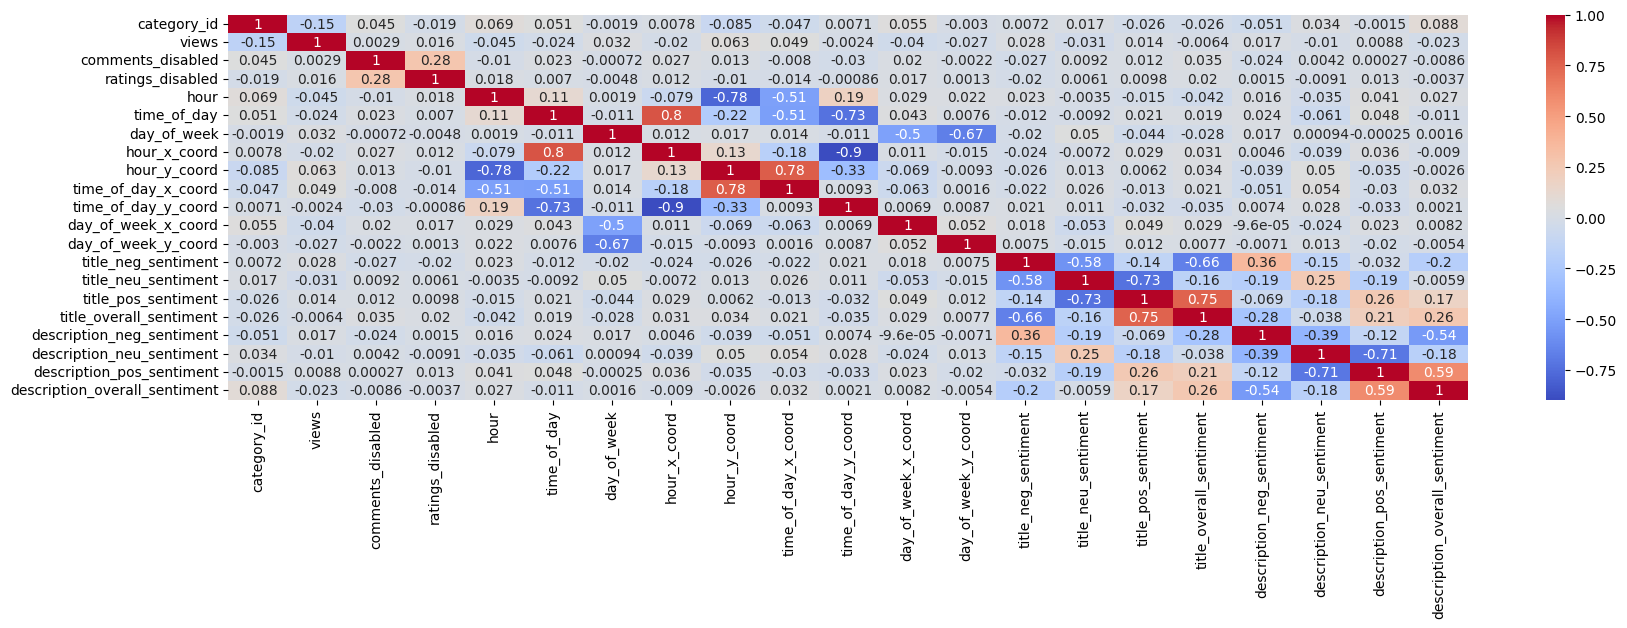

In [173]:
corr = youtube_df_eda[[col for col in youtube_df_eda.columns if col not in ['likes', 'dislikes', 'comment_count', 'publish_time', 'tags', 'description', 'title', 'channel_title', 'category_label']]].corr()
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)
plt.show()

### Univariate analysis - Comment count vs. Views

<Axes: xlabel='comment_count', ylabel='views'>

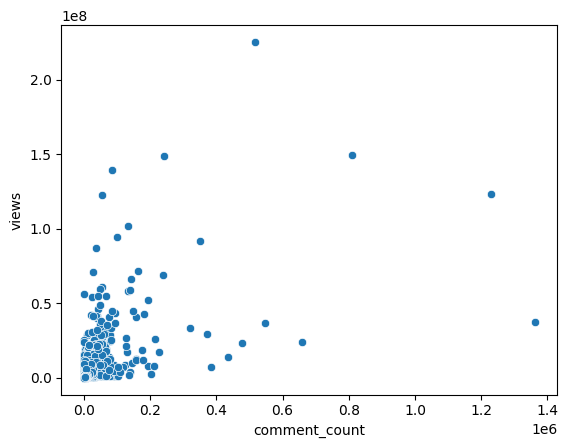

In [ ]:
ax = sns.scatterplot(data=youtube_df_eda, x="comment_count", y="views")
ax.set_yscale('log')

<Axes: xlabel='likes', ylabel='views'>

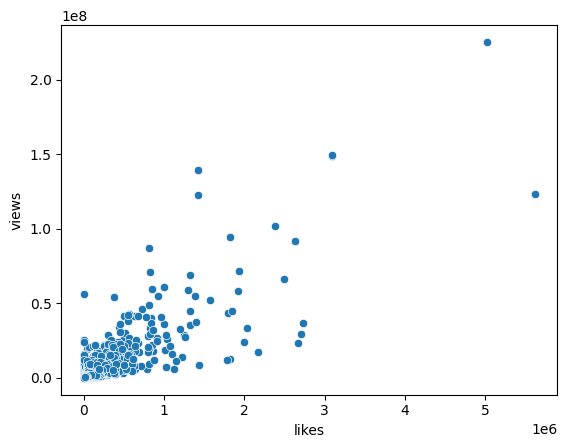

In [ ]:
ax = sns.scatterplot(data=youtube_df_eda, x="likes", y="views")
ax.set_yscale('log')

<Axes: xlabel='dislikes', ylabel='views'>

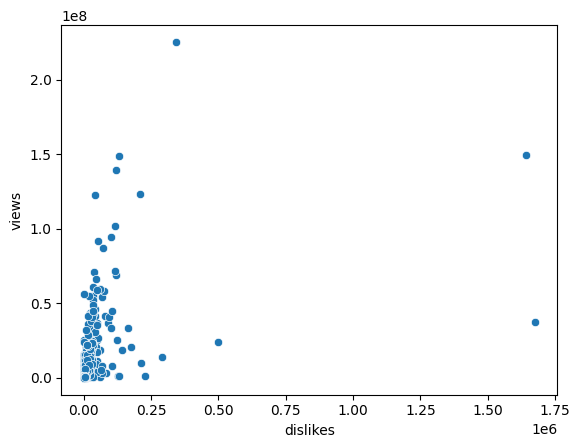

In [ ]:
ax = sns.scatterplot(data=youtube_df_eda, x="dislikes", y="views")
ax.set_yscale('log')

### Distribution of likes, dislikes, comment counts, and views

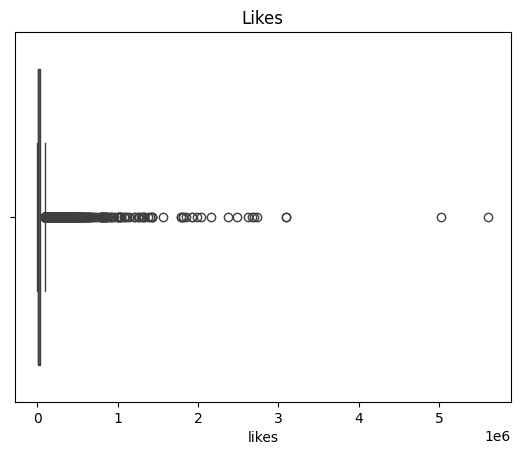

In [ ]:
sns.boxplot(x=youtube_df_eda['likes'])
plt.title('Likes')
plt.show()

Text(0.5, 1.0, 'Dislikes')

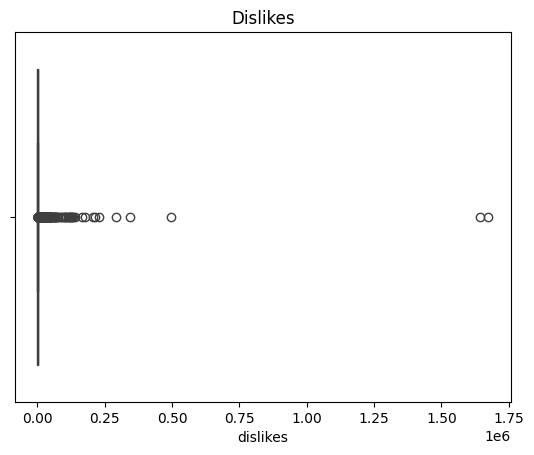

In [ ]:
sns.boxplot(x=youtube_df_eda['dislikes'])
plt.title('Dislikes')
plt.show()

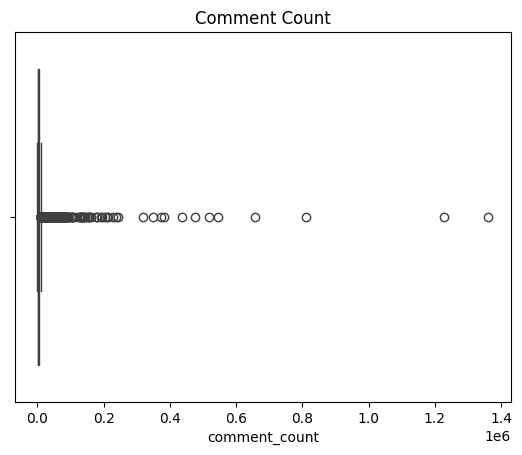

In [ ]:
sns.boxplot(x=youtube_df_eda['comment_count'])
plt.title('Comment Count')
plt.show()

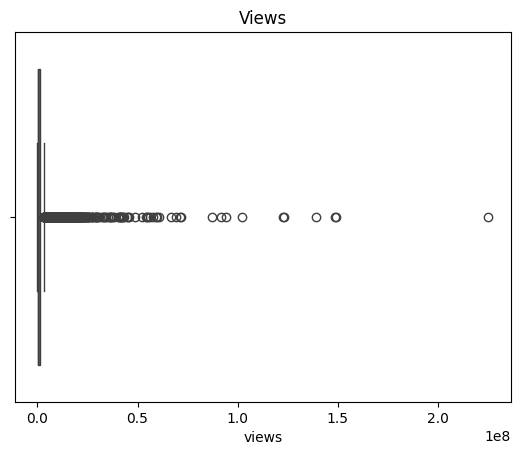

In [ ]:
sns.boxplot(x=youtube_df_eda['views'])
plt.title('Views')
plt.show()

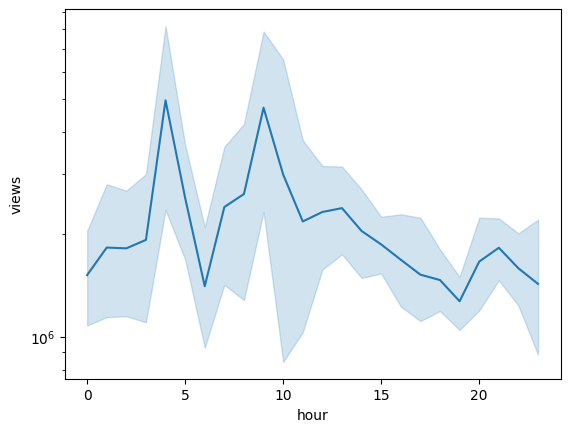

In [ ]:
ax = sns.lineplot(data=youtube_df, x='hour', y='views')
ax.set_yscale('log')


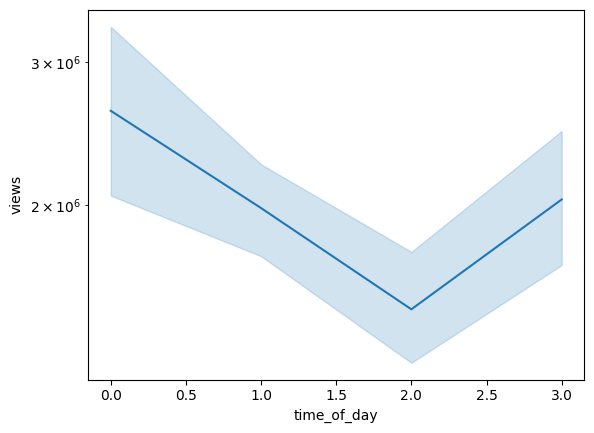

In [ ]:
ax = sns.lineplot(data=youtube_df, x='time_of_day', y='views')
ax.set_yscale('log')

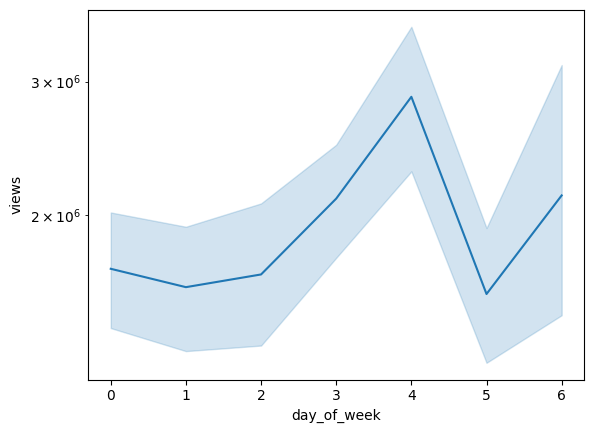

In [ ]:
ax = sns.lineplot(data=youtube_df, x='day_of_week', y='views')
ax.set_yscale('log')

### Bivariate analysis

### Model Selection and Evaluation

In [137]:
# Split data into train and test sets, but shuffle first since we sorted the data earlier
data = youtube_df.copy()
data = shuffle(data, random_state=19)
X = data[[
    'category_label',
    'hour_x_coord',
    'hour_y_coord',
    'time_of_day_x_coord',
    'time_of_day_y_coord',
    'day_of_week_x_coord',
    'day_of_week_y_coord',
    'comments_disabled',
    'ratings_disabled',
    'title_neg_sentiment',
    'title_neu_sentiment',
    'title_pos_sentiment',
    'title_overall_sentiment',
    'description_neg_sentiment',
    'description_neu_sentiment',
    'description_pos_sentiment',
    'description_overall_sentiment'
]]
y = data['views']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=19)

In [138]:
# Target encode the category label
encoder = TargetEncoder(target_type='continuous')

# Do this after splitting the data into test and training sets to avoid data leakage
X_train['category_labels_encoded'] = encoder.fit_transform(pd.DataFrame(X_train['category_label']), y_train)
X_train.drop(columns=['category_label'], inplace=True)

X_test['category_labels_encoded'] = encoder.transform(pd.DataFrame(X_test['category_label']))
X_test.drop(columns=['category_label'], inplace=True)
X_test.head()

hour_x_coord  hour_y_coord  time_of_day_x_coord  time_of_day_y_coord  \
841       0.965926  2.588190e-01        -1.836970e-16                 -1.0   
822      -1.000000  1.224647e-16         6.123234e-17                  1.0   
3679     -0.500000 -8.660254e-01         6.123234e-17                  1.0   
85       -0.866025 -5.000000e-01         6.123234e-17                  1.0   
1662     -0.965926 -2.588190e-01         6.123234e-17                  1.0   

      day_of_week_x_coord  day_of_week_y_coord  comments_disabled  \
841              0.623490             0.781831              False   
822             -0.900969            -0.433884              False   
3679            -0.900969            -0.433884              False   
85              -0.222521            -0.974928              False   
1662             0.623490             0.781831              False   

      ratings_disabled  title_neg_sentiment  title_neu_sentiment  \
841              False                  0.0                1.000   
822              False                  0.0                1.000   
3679             False                  0.0                0.885   
85               False                  0.0                1.000   
1662             False                  0.0                1.000   

      title_pos_sentiment  title_overall_sentiment  description_neg_sentiment  \
841                 0.000                   0.0000                        0.0   
822                 0.000                   0.0000                        0.0   
3679                0.115                   0.0772                        0.0   
85                  0.000                   0.0000                        0.0   
1662                0.000                   0.0000                        0.0   

      description_neu_sentiment  description_pos_sentiment  \
841                       1.000                      0.000   
822                       0.828                      0.172   
3679                      0.932                      0.068   
85                        0.847                      0.153   
1662                      0.830                      0.170   

      description_overall_sentiment  category_labels_encoded  
841                          0.0000             4.936772e+05  
822                          0.4003             1.351362e+06  
3679                         0.2263             1.848812e+06  
85                           0.9134             1.224749e+06  
1662                         0.9381             1.351362e+06

In [189]:
mae_diff = -5
print(f"MAE: {mae_diff}" if mae_diff < 0 else f"MAE: +{mae_diff}")

MAE: -5


In [221]:
baseline_scores = {}

def evaluate_model(y_test, y_pred):
  global baseline_scores

  mae = metrics.mean_absolute_error(y_test, y_pred)
  mse = metrics.mean_squared_error(y_test, y_pred)
  rmse = metrics.root_mean_squared_error(y_test, y_pred)
  r2 = metrics.r2_score(y_test, y_pred)

  print(f"Mean Absolute Error (MAE): {mae}")
  print(f"Mean Squared Error (MSE): {mse}")
  print(f"Root Mean Squared Error (RMSE): {rmse}")
  print(f"R^2: {r2}")

  if baseline_scores:
    print("\nChange from baseline:")
    mae_diff = mae - baseline_scores['mae']
    mse_diff = mse - baseline_scores['mse']
    rmse_diff = rmse - baseline_scores['rmse']
    r2_diff = r2 - baseline_scores['r2']
    print(f"MAE: {mae_diff}" if mae_diff < 0 else f"MAE: +{mae_diff}")
    print(f"MSE: {mse_diff}" if mse_diff < 0 else f"MSE: +{mse_diff}")
    print(f"RMSE: {rmse_diff}" if rmse_diff < 0 else f"RMSE: +{rmse_diff}")
    print(f"R2: {r2_diff}" if r2_diff < 0 else f"R2 +{r2_diff}")
  else:
    baseline_scores = {'mae': mae, 'mse': mse, 'rmse': rmse, 'r2': r2}

In [217]:
print(baseline_scores)

{}


In [209]:
bool(baseline_scores)

False

In [179]:
1852625.6907113295 - 1531424.2136113297

321201.4770999998

In [180]:
25100544489841.902 - 29761601149861.855

-4661056660019.953

In [181]:
5010044.360067274 - 5455419.429325472

-445375.0692581972

In [182]:
0.11449916461506127 - (-0.04993430286985845)

0.16443346748491972

In [222]:
# Create dummy baseline model
dummy_regr = DummyRegressor(strategy="median")
dummy_regr.fit(X_train, y_train)

y_pred = dummy_regr.predict(X_test)

evaluate_model(y_test, y_pred)

Mean Absolute Error (MAE): 1531424.2136113297
Mean Squared Error (MSE): 29761601149861.855
Root Mean Squared Error (RMSE): 5455419.429325472
R^2: -0.04993430286985845


In [224]:
search_grid = {'max_depth': range(2,10), 'min_samples_split': range(2,5)}

best_regr = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=search_grid, cv=2, scoring='r2', verbose=1)
best_regr.fit(X_train, y_train)

print(best_regr.best_params_)
print(best_regr.best_score_)

y_pred = best_regr.predict(X_test)

evaluate_model(y_test, y_pred)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
{'max_depth': 2, 'min_samples_split': 2}
-0.041484913488717745
Mean Absolute Error (MAE): 1952797.528119359
Mean Squared Error (MSE): 25915958995129.043
Root Mean Squared Error (RMSE): 5090771.944914548
R^2: 0.08573284737803988

Change from baseline:
MAE: +421373.31450802926
MSE: -3845642154732.8125
RMSE: -364647.4844109239
R2 +0.13566715024789833


In [223]:
#regr = DecisionTreeRegressor(max_depth=4, min_samples_split=50, min_impurity_decrease=0.1, min_samples_leaf=100, random_state=19)
regr = DecisionTreeRegressor(max_depth=4, random_state=19)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

evaluate_model(y_test, y_pred)

Mean Absolute Error (MAE): 1852625.6907113295
Mean Squared Error (MSE): 25100544489841.902
Root Mean Squared Error (RMSE): 5010044.360067274
R^2: 0.11449916461506127

Change from baseline:
MAE: +321201.4770999998
MSE: -4661056660019.953
RMSE: -445375.0692581972
R2 +0.16443346748491972


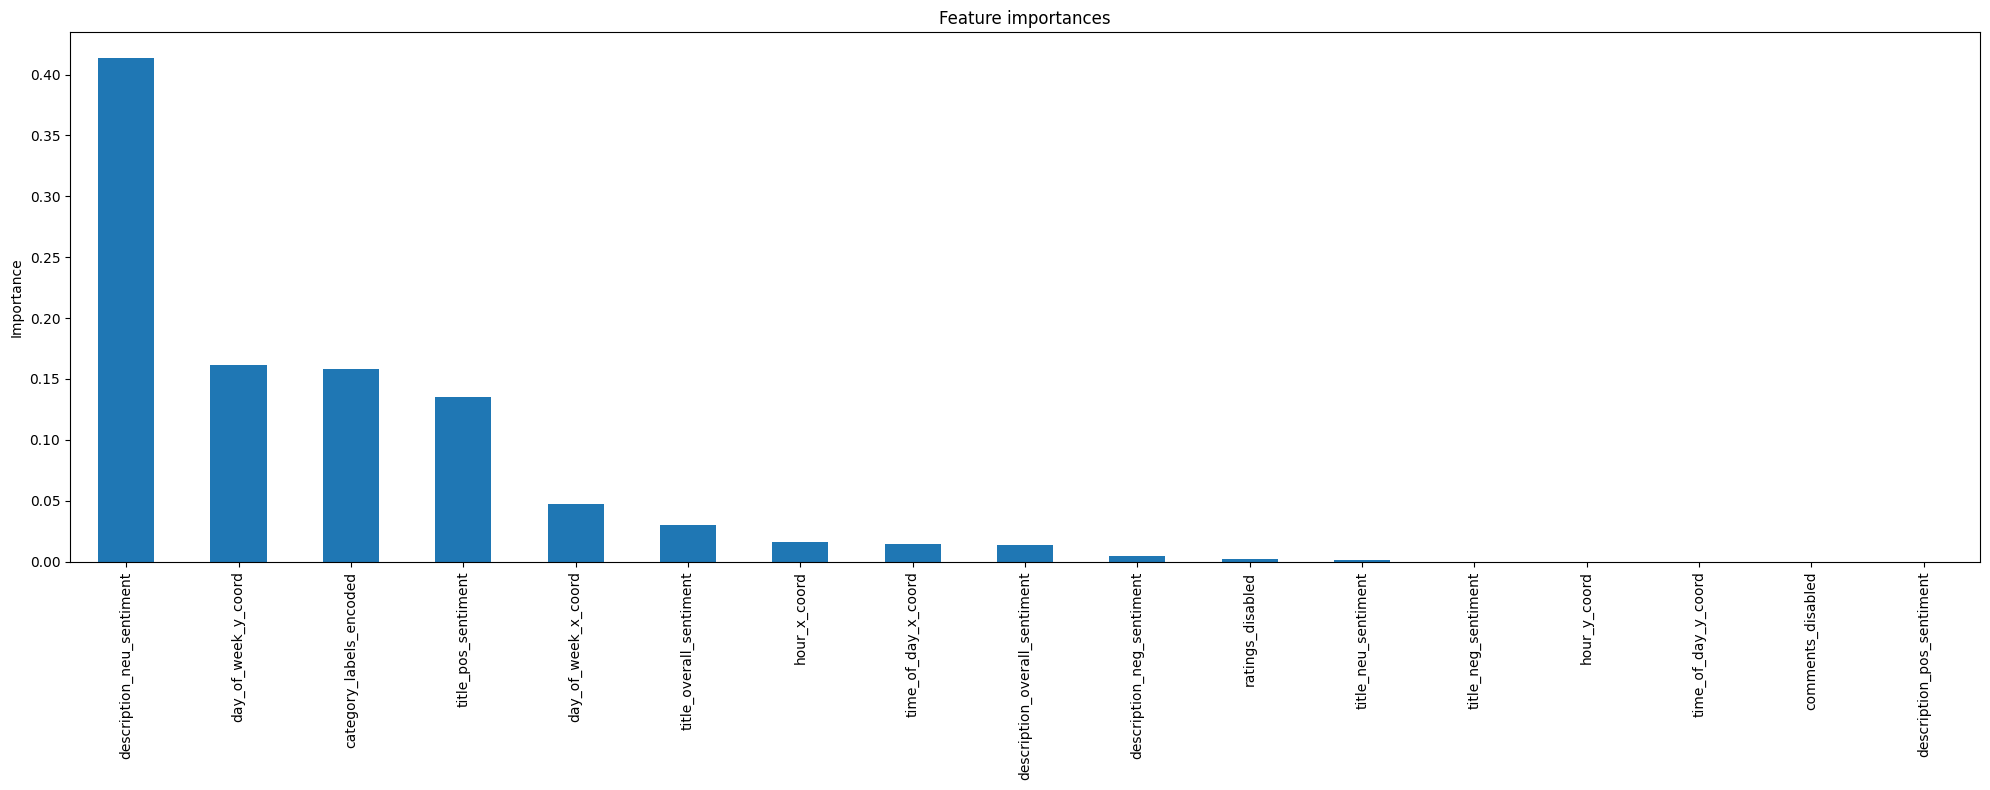

In [225]:
# Get the feature importances
importances = regr.feature_importances_
feature_names = list(X_test.columns)
feature_importances = list(zip(feature_names, importances))

# Sort feature importances in descending order
feature_importances.sort(key=lambda a: a[1], reverse=True)

# Plot feature importances
names, importances = zip(*feature_importances)
tree_importances = pd.Series(importances, index=names)

fig, ax = plt.subplots(figsize=(20, 8))
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Importance")
fig.tight_layout()

In [226]:
fig, ax = plt.subplots(figsize=(20,5), dpi=3000)
ax = plot_tree(regr, filled=True, feature_names=feature_names)
plt.show()

In [154]:
search_grid = {'n_estimators': range(10,180,10), 'max_depth': range(2,10)}

best_rfr = GridSearchCV(estimator=RandomForestRegressor(), param_grid=search_grid, cv=2, scoring='r2', verbose=1)
best_rfr.fit(X_train, y_train)

print(best_rfr.best_params_)
print(best_rfr.best_score_)

y_pred = best_rfr.predict(X_test)

evaluate_model(y_test, y_pred)

Fitting 2 folds for each of 136 candidates, totalling 272 fits
{'max_depth': 2, 'n_estimators': 10}
0.012396767633680528
Mean Absolute Error (MAE): 1996135.863805783
Mean Squared Error (MSE): 26179546953256.22
Root Mean Squared Error (RMSE): 5116595.250091238
R^2: 0.07643395120415486


In [227]:
rfr = RandomForestRegressor(n_estimators=107, max_depth=4, random_state=0)
rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

evaluate_model(y_test, y_pred)

Mean Absolute Error (MAE): 1888475.1731826041
Mean Squared Error (MSE): 25224104970307.57
Root Mean Squared Error (RMSE): 5022360.497844372
R^2: 0.11014017914694951

Change from baseline:
MAE: +357050.95957127446
MSE: -4537496179554.285
RMSE: -433058.9314810997
R2 +0.16007448201680796


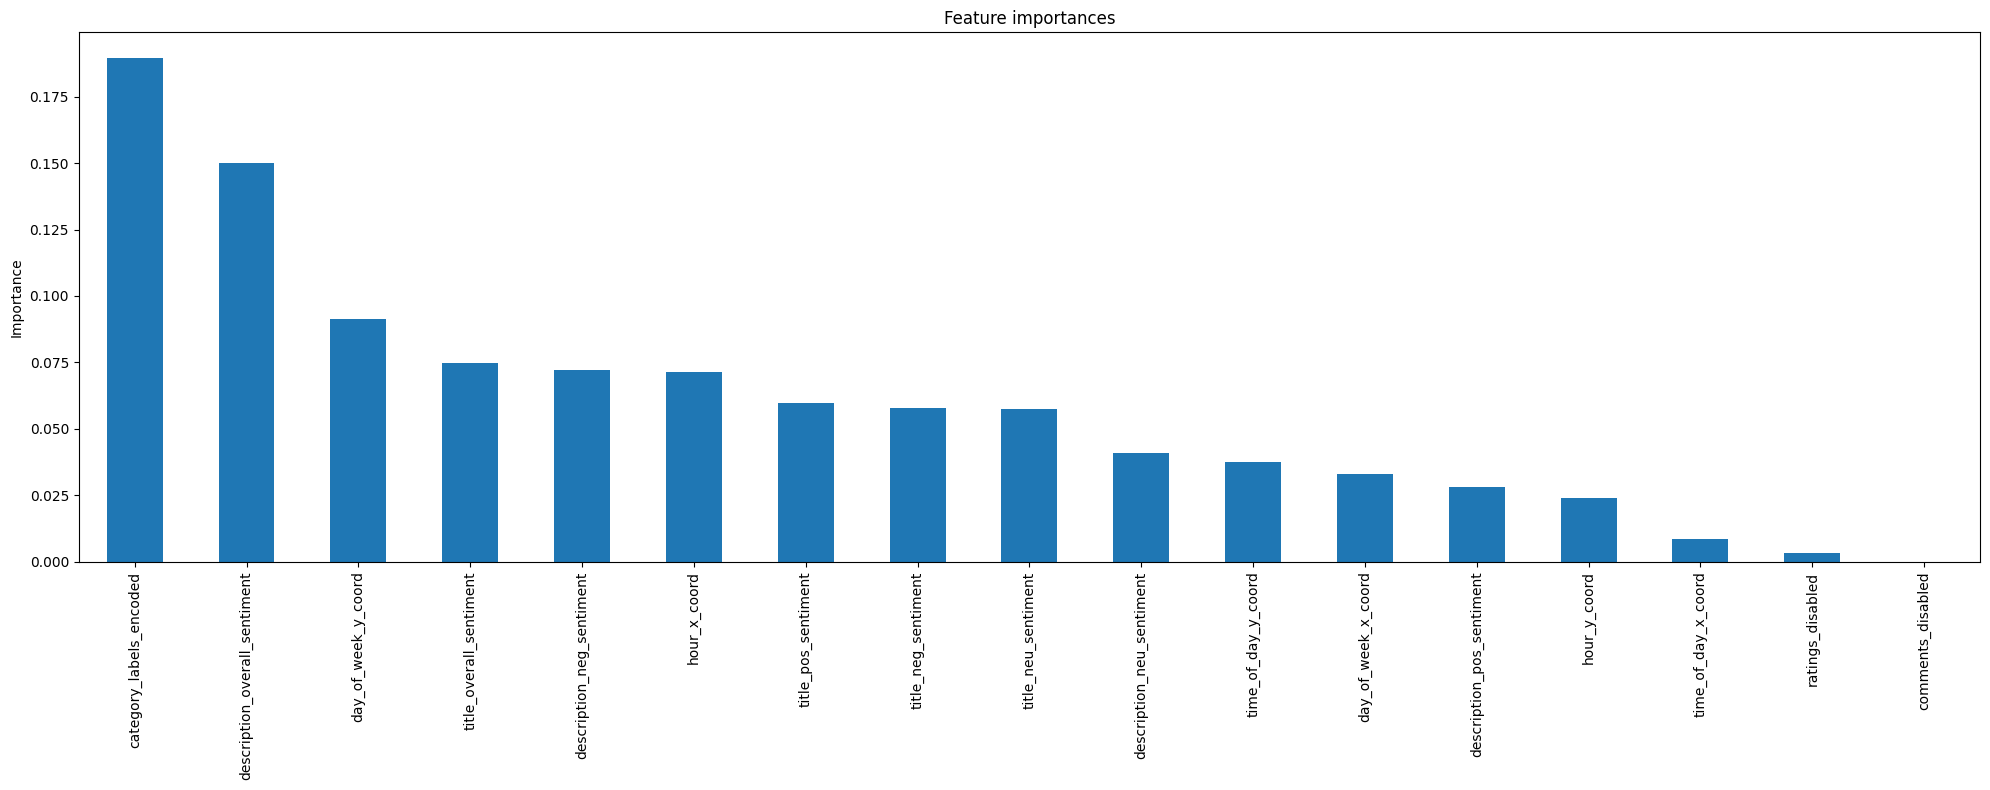

In [155]:
# Get the feature importances
importances = rfr.feature_importances_
feature_names = list(X_test.columns)
feature_importances = list(zip(feature_names, importances))

# Sort feature importances in descending order
feature_importances.sort(key=lambda a: a[1], reverse=True)

# Plot feature importances
names, importances = zip(*feature_importances)
tree_importances = pd.Series(importances, index=names)

fig, ax = plt.subplots(figsize=(20, 8))
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Importance")
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4), dpi=3000)
for index in range(3):
  plot_tree(rfr.estimators_[index], feature_names=feature_names, filled=True, ax=axes[index])
  axes[index].set_title('Estimator: ' + str(index), fontsize = 9)

### YouTube Data API Experiments

In [35]:
# Since channel title is not useful by itself, we will attempt to use YouTube's
# API to get the subscriber count for each channel as a measure of channel
# popularity, which is a generalizable concept. We will also use video count as
# a measure of creator activity

# Set up credentials
# NOTE: Disable OAuthlib's HTTPS verification when running locally.
# *DO NOT* leave this option enabled in production.
os.environ["OAUTHLIB_INSECURE_TRANSPORT"] = "1"

api_service_name = "youtube"
api_version = "v3"
developer_key = userdata.get('YOUTUBE-API-KEY')
scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

youtube = googleapiclient.discovery.build(
    api_service_name, api_version, developerKey=developer_key)

# Try getting results for just one channel
# The quota cost of this call is 1 unit
request = youtube.channels().list(
    part="statistics",
    forUsername="LastWeekTonight"
)
# Extract values from the JSON response
response = request.execute()
print(response['items'][0]['statistics'])

{'viewCount': '3898464116', 'subscriberCount': '9480000', 'hiddenSubscriberCount': False, 'videoCount': '519'}


In [ ]:
# Create an object to store the statistics for each channel
channel_statistics = {}

# Get list of unique channel names
channel_names = list(youtube_df['channel_title'].unique())

for channel in channel_names:
  # Send request for each channel
  request = youtube.channels().list(
      part="statistics",
      forUsername=channel
  )

  # Extract values from the JSON response and add to the statistics dictionary
  response = request.execute()

  if response['pageInfo']['totalResults'] > 0:
    subscriber_count = response['items'][0]['statistics']['subscriberCount']
    video_count = response['items'][0]['statistics']['videoCount']
    channel_statistics[channel] = {'subscriber_count': subscriber_count, 'video_count': video_count}
  else:
    channel_statistics[channel] = {'subscriber_count': np.nan, 'video_count': np.nan}

In [38]:
# The quota cost of this call is 100 units
request = youtube.search().list(
      part="snippet",
      q="LastWeekTonight",
      type="channel",
      maxResults=1,
  )
response = request.execute()
print(response)
print(response['items'][0]['snippet'])

{'kind': 'youtube#searchListResponse', 'etag': 'no-af8qMyQAJ8HvZv-qv0KpOvbI', 'nextPageToken': 'CAEQAA', 'regionCode': 'US', 'pageInfo': {'totalResults': 1114, 'resultsPerPage': 1}, 'items': [{'kind': 'youtube#searchResult', 'etag': '5WegvSYZ6lFC17a4eWIBpergO8I', 'id': {'kind': 'youtube#channel', 'channelId': 'UC3XTzVzaHQEd30rQbuvCtTQ'}, 'snippet': {'publishedAt': '2014-03-18T17:41:39Z', 'channelId': 'UC3XTzVzaHQEd30rQbuvCtTQ', 'title': 'LastWeekTonight', 'description': 'Breaking news on a weekly basis. Sundays at 11PM - only on HBO. Subscribe to the Last Week Tonight channel for the latest ...', 'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/qg5Rha7Rm_CWTiIZyisLT_13jr65Xr2fNOWPLQazI5QaoUUlskyMS8yvqG2DSPD6Y0Dil7z4NEI=s88-c-k-c0xffffffff-no-rj-mo'}, 'medium': {'url': 'https://yt3.ggpht.com/qg5Rha7Rm_CWTiIZyisLT_13jr65Xr2fNOWPLQazI5QaoUUlskyMS8yvqG2DSPD6Y0Dil7z4NEI=s240-c-k-c0xffffffff-no-rj-mo'}, 'high': {'url': 'https://yt3.ggpht.com/qg5Rha7Rm_CWTiIZyisLT_13jr65Xr2fNOWPLQazI5

In [ ]:
# Try getting channel ids instead
found = 0
for channel in channel_names:
  channel_cleaned = ''.join(channel.lower().split())
  request = youtube.search().list(
      part="snippet",
      q=channel_cleaned,
      type="channel",
      maxResults=1,
  )
  response = request.execute()

  if response['pageInfo']['totalResults'] > 0:
    result = response['items'][0]['snippet']['title']
    result_cleaned = ''.join(result.lower().split())
    if channel_cleaned == result_cleaned:
      channel_id = response['items'][0]['id']['channelId']
      found += 1

print("found ", found)
print("not found ", len(channel_names) - found)

In [ ]:
# Cache results to file
with open("channel_statistics.json", "w") as outfile:
    json.dump(channel_statistics, outfile)

In [ ]:
# Load channel statistics into a dataframe for analysis
df = pd.DataFrame.from_dict(channel_statistics, orient='index')
df.info(verbose=True)